# Prediction model to predict whether patients are on track to meet the weight loss standards of thier program.

## Import required libraries and load the datasets

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
#Load the required datasets into dataframes
df1=pd.read_csv("treatments.csv")
df2=pd.read_csv("users.csv")
df3=pd.read_csv("weights.csv")

In [39]:
# We need to merge these datasets on MasterUserID column to get one common dataset
# Rename the UID column of User dataset to MasterUserID so that we can merge the datasets
df2=df2.rename(columns={"UID":"MasterUserID"})

# Merge weights and user datasets
df3=pd.merge(df3, df2, on='MasterUserID', how='left')

#Merge previous dataset with treatments datasets
df3=pd.merge(df3, df1, on='MasterUserID', how='left')

In [40]:
#Columns of common dataset
df3.columns

Index(['MasterUserID', 'Weight', 'BMI', 'BodyFat', 'BodyWater', 'Bone',
       'VisceralFat', 'BMR', 'MuscleMass', 'CreatedDate_x', 'UpdatedDate',
       'IsActive_x', 'IsDelete', 'Name', 'LastName', 'Gender', 'Unit',
       'Birthday', 'Age', 'Height', 'CreatedDate_y', 'IsActive_y', 'ClinicID',
       'loginId', 'success', 'TreatmentTypeID', 'StartDate'],
      dtype='object')

## Data preprocessing

In [41]:
# Drop duplicate columns created by mereging of datsets.
columns_to_drop=["IsActive_y","CreatedDate_y"]
df3.drop(columns_to_drop, axis=1, inplace=True)

In [42]:
#Columns such as IsActive_x,IsDelete,TreatmentTypeID, and ClinicID contain only one type of value.Hence, these variables won't contribute to our prediction.
#Variables Created date and Updated date have same values. It's better to drop one of them.
#LoginID is an empty column.
#MasterUserID, Name,and LastName won't contribute to our prediction.
#We have age column. We don't need birthday column anymore.

columns_to_drop=["IsActive_x","IsDelete","UpdatedDate","ClinicID","loginId","TreatmentTypeID","Name","LastName"]
df3.drop(columns_to_drop, axis=1, inplace=True)


In [43]:
#Encode categorical variables such as success and gender into binary values using labelencoder
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# Fit and transform the 'gender' column
df3['Gender'] = encoder.fit_transform(df3['Gender'])
df3['success'] = encoder.fit_transform(df3['success'])


In [44]:
# Drop HH:MM:SS values from start date and created date columns
df3['CreatedDate_x'] = pd.to_datetime(df3['CreatedDate_x'])

df3['CreatedDate_x'] = df3['CreatedDate_x'].dt.date

df3['StartDate'] = pd.to_datetime(df3['StartDate'])

df3['StartDate'] = df3['StartDate'].dt.date

## Feature Engineering




In [45]:
##We have to columns to start date of treatment and date of record creation.
##These two columns won't contribute to prediction if considereed individually.
##So, it's better to find a way to combine these two columns to get a one single value which will give use useful information.
##We can subtract these values and can get the number of days from start date of treatment to date of record creation.
df3['Days count'] = (df3['CreatedDate_x']-df3['StartDate']).dt.days

In [46]:
## Now I want to add the starting weight of each patient against each record of the patient

df3['min_time'] = df3.groupby('MasterUserID')['Days count'].transform('min')

# Filter the DataFrame to keep only the rows with the minimum time value
result_df = df3[df3['Days count'] == df3['min_time']]

# Merge the result with the original DataFrame to add the weight at the minimum time value
final_result = pd.merge(df3, result_df[['MasterUserID', 'Weight']], on='MasterUserID', how='left', suffixes=('', '_min_time'))

# Rename the added column
final_result.rename(columns={'Weight_min_time': 'weight_at_min_time'}, inplace=True)


In [47]:
final_result.rename(columns={'weight_at_min_time': 'start_weight'}, inplace=True)

In [48]:
final_result.dtypes

MasterUserID      object
Weight           float64
BMI              float64
BodyFat          float64
BodyWater        float64
Bone             float64
VisceralFat      float64
BMR              float64
MuscleMass       float64
CreatedDate_x     object
Gender             int64
Unit               int64
Birthday          object
Age                int64
Height             int64
success            int64
StartDate         object
Days count         int64
min_time           int64
start_weight     float64
dtype: object

In [49]:
columns_to_drop=["StartDate","CreatedDate_x","Birthday","min_time","MasterUserID"]
final_result.drop(columns_to_drop, axis=1, inplace=True)

In [60]:
final_result.dtypes


Weight          float64
BMI             float64
BodyFat         float64
BodyWater       float64
Bone            float64
VisceralFat     float64
BMR             float64
MuscleMass      float64
Gender            int64
Unit              int64
Age               int64
Height            int64
success           int64
Days count        int64
start_weight    float64
dtype: object

## Exploratory Data Analysis (Check for outliers and data imbalance)

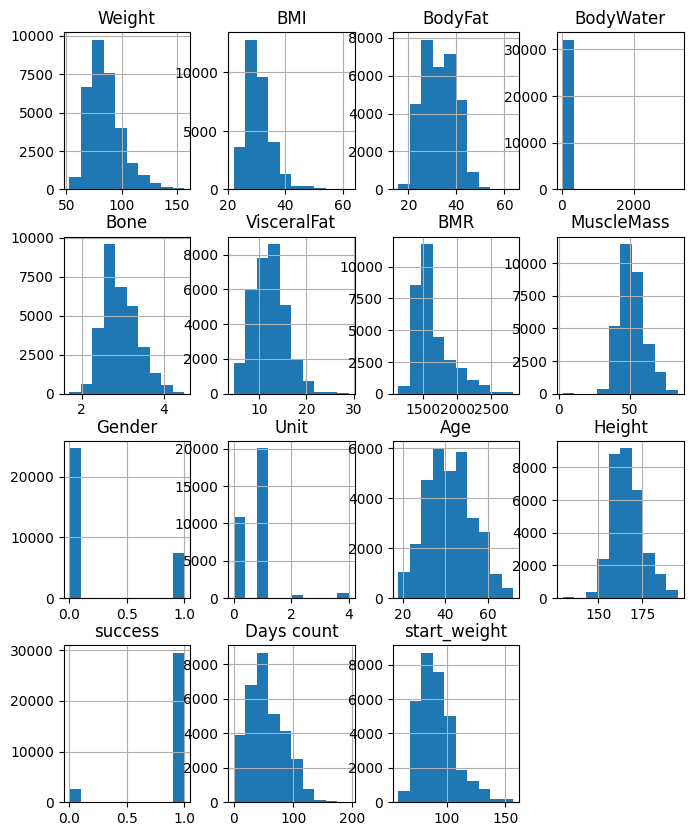

In [74]:
final_result.hist(figsize=(8, 10))
plt.show()

#### All numeric variables are normally distributed. Hence, we don't need to normalize these columns

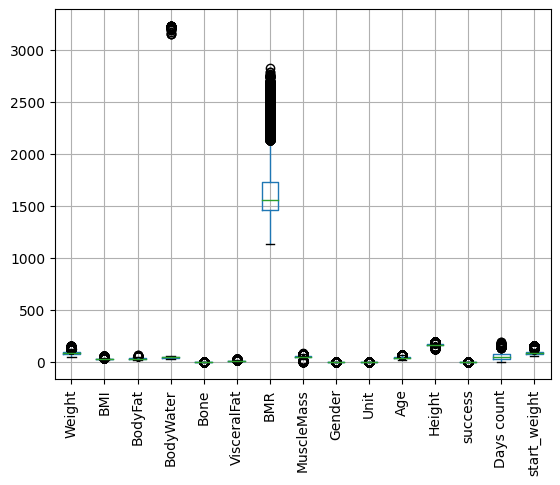

In [65]:
# Plot boxplot for each column
ax=final_result.boxplot()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

#### Except for BMR column, outliers are not present. BMR column in not correlated with success heavily. Hence, keeping outliers will not cause extreme biased prediction

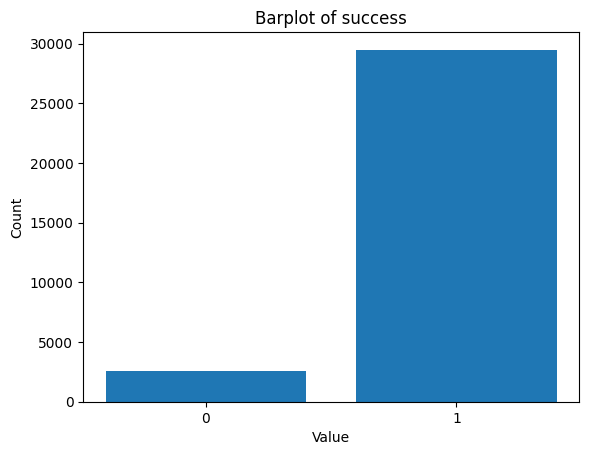

In [69]:
# Count the occurrences of 0 and 1 in the success
value_counts = final_result['success'].value_counts()

# Plot a barplot
plt.bar(value_counts.index, value_counts.values, tick_label=['1', '0'])
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Barplot of success')
plt.show()

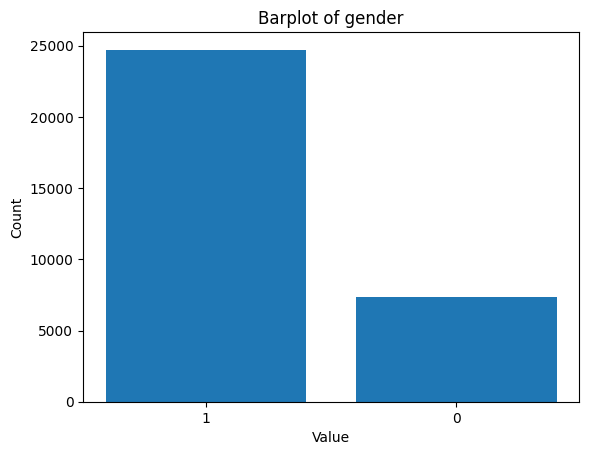

In [71]:
value_counts = final_result['Gender'].value_counts()

# Plot a barplot
plt.bar(value_counts.index, value_counts.values, tick_label=['1', '0'])
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Barplot of gender')
plt.show()

#### Dataset is highly imbalanced. Number of failed patients is very less when compared to number of passed patients. Hence, we need to balance the dataset in future to make out machine learning model more robust.




## Machine Learning Model

### We need to check whether patients are on track to meet the weight loss standards of thier program. For this purpose, we will need to build a classification model. The target ( y variable ) will be success. The remaining variables are independant (x variable).

In [76]:
#Separate the independant variables from dependant variable
feature_cols = [ 'Weight', 'BMI', 'BodyFat', 'BodyWater', 'Bone',
       'VisceralFat', 'BMR', 'MuscleMass','Gender',
       'Unit', 'Age', 'Height','Days count', 'start_weight']
X = final_result[feature_cols] # Features
y = final_result.success # Target variable

In [78]:
#Split the dataset into train and test dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.25, random_state=16)

In [79]:
#### Let's check the distribution of success variable in both train and test dataset
print("total no. of passed patients in train",sum(y_train))
print("total no. of passed patients in test",sum(y_test))
print("total no. of failed patients in train",(len(y_train)-sum(y_train)))
print("total no. of failed patients in test",(len(y_test)-sum(y_test)))

total no. of passed patients in train 22100
total no. of passed patients in test 7402
total no. of failed patients in train 1954
total no. of failed patients in test 617


#### It's worth noting that percentage of passed patients in test dataset is 7402/8019 = 92.30%
#### Hence, dataset is highly imbalanced and even if our model predicts that patient is going to succedd everytime, the accuracy will be 92.30 %

### Logistic Regression
#### Let's start with the simple logistic regression model. As dataset is large and highly imbalanced, logitic regression is expected to perform poorly. We need to verify this hypothesis before moving to more complex model

Accuracy score of logistic regression is 0.943509165731388


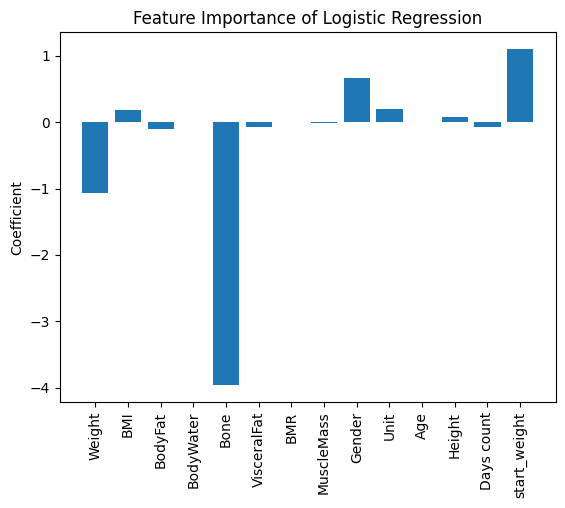

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

model = LogisticRegression(max_iter=10000)


# Fit the model on the training dataset
model.fit(X_train, y_train)



# Make predictions
y_pred = model.predict(X_test)

# Get feature importance (in this case, there's only one feature)
feature_importance = model.coef_[0]
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score of logistic regression is",accuracy)
# Plot feature importance
plt.bar(X.columns, feature_importance)
plt.xticks(rotation='vertical')  # Rotate x-axis labels
plt.title("Feature Importance of Logistic Regression")
plt.ylabel("Coefficient")
plt.show()


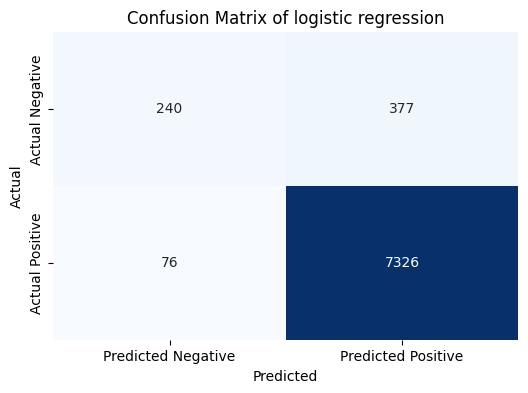

In [82]:
import numpy as np
from sklearn.metrics import confusion_matrix


# Create a confusion matrix
confusion = confusion_matrix(y_test,y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of logistic regression')
plt.show()

In [85]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='binary')

print("Precision of logistic regression:", precision)
print("Recall of logistic regression:", recall)
print("F1 Score of logistic regression:", f1_score)

roc_auc = roc_auc_score(y_test, y_pred)

print("ROC AUC Score of logictic regression:", roc_auc)

Precision of logistic regression: 0.9510580293392185
Recall of logistic regression: 0.9897325047284518
F1 Score of logistic regression: 0.9700099304865938
ROC AUC Score of logictic regression: 0.6893557175181967


### Logistic regression is not performing satisfactorily.
#### Our dataset is large and highly imbalanced. Also our final goal is to increase the predictive power instead of focusing on interpretabilty of our model. Hence, we will build ensemble ML models. We will impelement three models for each ensemble models.
#### Bagging : Random Forest
#### Boosting : XGBoost
#### Stacking Ensemble

## Random Forest

In [86]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object to find the best parameters for our model
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100]})

Accuracy score of Random Forest is 0.9980047387454795
Best parameters for random forest are {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


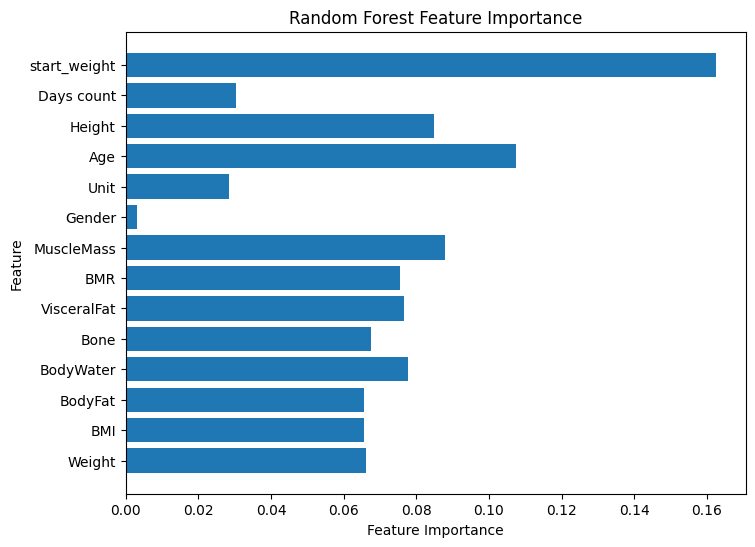

In [87]:
#Choose the best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score of Random Forest is",accuracy)
print("Best parameters for random forest are",grid_search.best_params_)

#Plot feature importance
feature_importance = best_model.feature_importances_

# Get the feature names
feature_names = X.columns

# Create a bar chart for feature importance
plt.figure(figsize=(8, 6))
plt.barh(feature_names, feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()

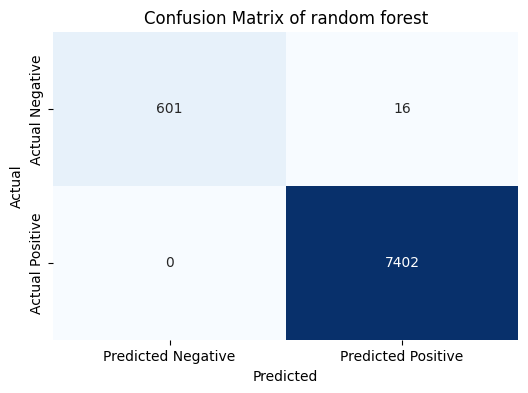

In [88]:
import numpy as np
from sklearn.metrics import confusion_matrix


# Create a confusion matrix
confusion = confusion_matrix(y_test,y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of random forest')
plt.show()

In [89]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='binary')

print("Precision of random forest:", precision)
print("Recall of random forest:", recall)
print("F1 Score of random forest:", f1_score)

roc_auc = roc_auc_score(y_test, y_pred)

print("ROC AUC Score of random forest:", roc_auc)

Precision of random forest: 0.9978430843893232
Recall of random forest: 1.0
F1 Score of random forest: 0.9989203778677463
ROC AUC Score of random forest: 0.987034035656402


## XGBoost

In [90]:
import xgboost as xgb
model = xgb.XGBClassifier()

# Define a parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'objective': ['binary:logistic']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')

# Train the model with GridSearchCV
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'n_estimators': [50, 100, 200],
                         'objective': ['binary:logistic']},
             scoring='accuracy')

Accuracy score of XGBoost is 0.9985035540591096
Best parameters for XGBoost are {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'objective': 'binary:logistic'}


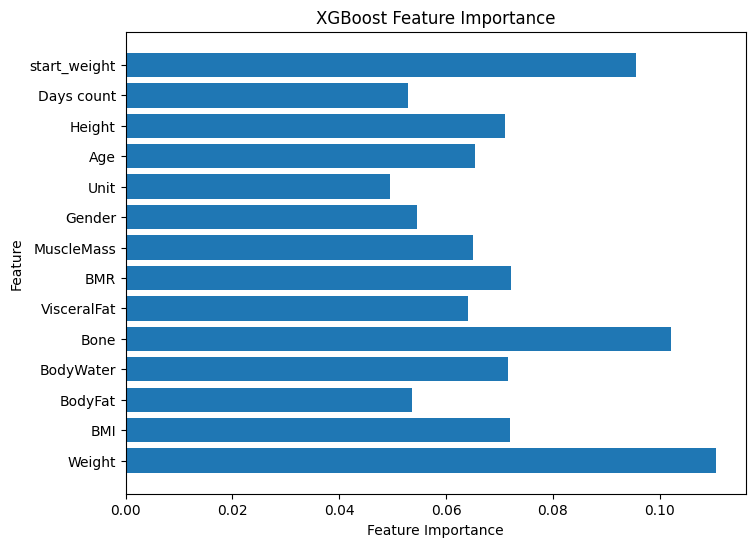

In [91]:
#Choose the best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score of XGBoost is",accuracy)
print("Best parameters for XGBoost are",grid_search.best_params_)

#Plot feature importance
feature_importance = best_model.feature_importances_

# Get the feature names
feature_names = X.columns

# Create a bar chart for feature importance
plt.figure(figsize=(8, 6))
plt.barh(feature_names, feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.show()

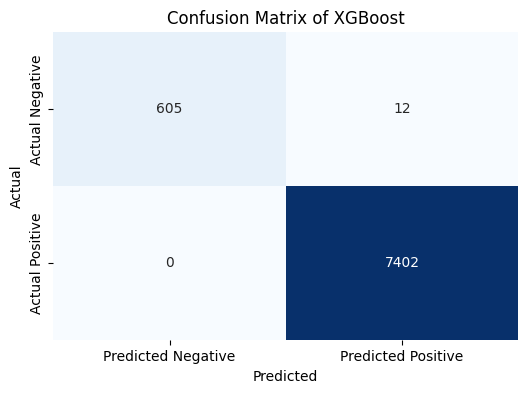

In [92]:
import numpy as np
from sklearn.metrics import confusion_matrix


# Create a confusion matrix
confusion = confusion_matrix(y_test,y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of XGBoost')
plt.show()

In [93]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='binary')

print("Precision of XGBoost:", precision)
print("Recall of XGBoost:", recall)
print("F1 Score of XGBoost:", f1_score)

roc_auc = roc_auc_score(y_test, y_pred)

print("ROC AUC Score of XGBoost:", roc_auc)

Precision of XGBoost: 0.9983814405179391
Recall of XGBoost: 1.0
F1 Score of XGBoost: 0.9991900647948164
ROC AUC Score of XGBoost: 0.9902755267423015


## Stacking Model
### Random forest and XGBoost are performing better than logistic regression
### Stacking is an ensemble machine learning algorithm that learns how to best combine the predictions from multiple well-performing machine learning models. So, we will combine the predictions of logistic regression, random forest model, and XGBoost model.

In [101]:

from sklearn.ensemble import StackingClassifier
base_models = [
    ('logreg', LogisticRegression(max_iter=10000)),
    ('rf', RandomForestClassifier(max_depth=20,min_samples_leaf=1,n_estimators=50,min_samples_split=2,random_state=42)),
    ('xgb',xgb.XGBClassifier(learning_rate=0.2,max_depth=5,n_estimators=200, random_state=42))
]

# Initialize the StackingClassifier with a meta-model (here we use LogisticRegression)
stacked_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(max_iter=10000),cv=5)

# Train the stacked model on the training data
stacked_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = stacked_model.predict(X_test)


In [102]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score of XGBoost is",accuracy)


Accuracy score of XGBoost is 0.9988776655443322


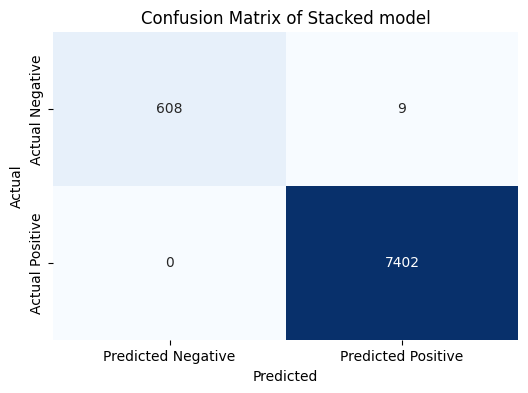

In [103]:
import numpy as np
from sklearn.metrics import confusion_matrix


# Create a confusion matrix
confusion = confusion_matrix(y_test,y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Stacked model')
plt.show()

In [104]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='binary')

print("Precision of stacked model:", precision)
print("Recall of stacked modelt:", recall)
print("F1 Score of stacked model:", f1_score)

roc_auc = roc_auc_score(y_test, y_pred)

print("ROC AUC Score of stacked model:", roc_auc)

Precision of stacked model: 0.9987855889893402
Recall of stacked modelt: 1.0
F1 Score of stacked model: 0.9993924255721326
ROC AUC Score of stacked model: 0.992706645056726


## Conclusion and recommendations

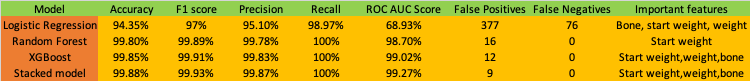




#### We can see that stacked model gives us the highest accuracy. Number of false predictions is least in case of stacked model. The highest ROC AUC score of stacked model suggests that the model is capable of distinguishing between the classes with a high degree of accuracy. Hence, I propose that stacked model is the best prediction model that predicts whether patients are on track to meet the weight loss standards of thier program.

#### Patients intial weight, current weight, and bone value are very important in determing the success of program for the given patient. Other variables also have significant importance. But they are not as important as these three variables.

#### In future, we need to collect more samples of failed patients as well so that we can get a balanced dataset. This reduces the model bias and makes model more robust. This will allow us to reach the accurate predictions using simple models instead of using complex models, saving significant computational power and computational cost. It will be benificial to include information about patients total no. of engagements as well.

